## Logit Model with HMC

The details are from [here](https://cran.r-project.org/web/packages/hmclearn/vignettes/logistic_regression_hmclearn.html). 

The log posterior for logistic regression is given by the sum of the log likelihood and the log prior:

$$
\log p(\boldsymbol{\beta} | \mathbf{y}, \mathbf{X}) = \log p(\mathbf{y} | \mathbf{X}, \boldsymbol{\beta}) + \log p(\boldsymbol{\beta})
$$

The log likelihood for logistic regression is given by:

$$
\log p(\mathbf{y} | \mathbf{X}, \boldsymbol{\beta}) = \sum_{i=1}^{n} \left[ y_i \log \left( \frac{1}{1 + \exp(-\mathbf{x}_i^T \boldsymbol{\beta})} \right) + (1 - y_i) \log \left( 1 - \frac{1}{1 + \exp(-\mathbf{x}_i^T \boldsymbol{\beta})} \right) \right]
$$

The log prior for a Gaussian distribution is given by:

$$
\log p(\boldsymbol{\beta}) = -\frac{1}{2} \boldsymbol{\beta}^T \boldsymbol{\Sigma}^{-1} \boldsymbol{\beta} + \text{const}
$$

where $\boldsymbol{\Sigma}$ is the covariance matrix of the Gaussian prior.

The gradient of the log posterior with respect to $\boldsymbol{\beta}$ is given by the sum of the gradient of the log likelihood and the gradient of the log prior:

$$
\nabla \log p(\boldsymbol{\beta} | \mathbf{y}, \mathbf{X}) = \nabla \log p(\mathbf{y} | \mathbf{X}, \boldsymbol{\beta}) + \nabla \log p(\boldsymbol{\beta})
$$

The gradient of the log likelihood with respect to $\boldsymbol{\beta}$ is given by:

$$
\nabla \log p(\mathbf{y} | \mathbf{X}, \boldsymbol{\beta}) = \mathbf{X}^T (\mathbf{y} - \mathbf{p})
$$

where $\mathbf{p} = (p_1, ..., p_n)^T$ and $p_i = 1 / (1 + \exp(-\mathbf{x}_i^T \boldsymbol{\beta}))$.

The gradient of the log prior with respect to $\boldsymbol{\beta}$ is given by:

$$
\nabla \log p(\boldsymbol{\beta}) = -\boldsymbol{\Sigma}^{-1} \boldsymbol{\beta}
$$

In [27]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def log_likelihood(X, y, beta):
    z = X @ beta
    return y @ z - np.log(1 + np.exp(z)).sum()

def grad_log_likelihood(X, y, beta):
    z = X @ beta
    return X.T @ (y - sigmoid(z))

def HMC(X, y, epsilon, L, current_beta):
    beta = current_beta.copy()
    p = np.random.normal(size=beta.shape)  # independent standard normal variates
    current_p = p.copy()

    # Make a half step for momentum at the beginning
    p += epsilon * grad_log_likelihood(X, y, beta) / 2

    # Alternate full steps for position and momentum
    for i in range(L):
        # Make a full step for the position
        beta += epsilon * p

        # Make a full step for the momentum, except at end of trajectory
        if i != L - 1:
            p += epsilon * grad_log_likelihood(X, y, beta)

    # Make a half step for momentum at the end.
    p += epsilon * grad_log_likelihood(X, y, beta) / 2

    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p

    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = -log_likelihood(X, y, current_beta)
    current_K = sum(current_p**2) / 2
    proposed_U = -log_likelihood(X, y, beta)
    proposed_K = sum(p**2) / 2

    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    if np.random.uniform() < np.exp(current_U - proposed_U + current_K - proposed_K):
        return beta  # accept
    else:
        return current_beta  # reject

# Test the HMC function
np.random.seed(0)
X = np.random.normal(size=(100, 2))
X = np.hstack([np.ones((100, 1)), X])  # add intercept
true_beta = np.array([0, 1, 2])
y = np.random.binomial(1, sigmoid(X @ true_beta))
epsilon = 0.1
L = 10
samples = []
for _ in range(1000):
    current_beta = HMC(X, y, epsilon, L, current_beta)
    samples.append(current_beta)

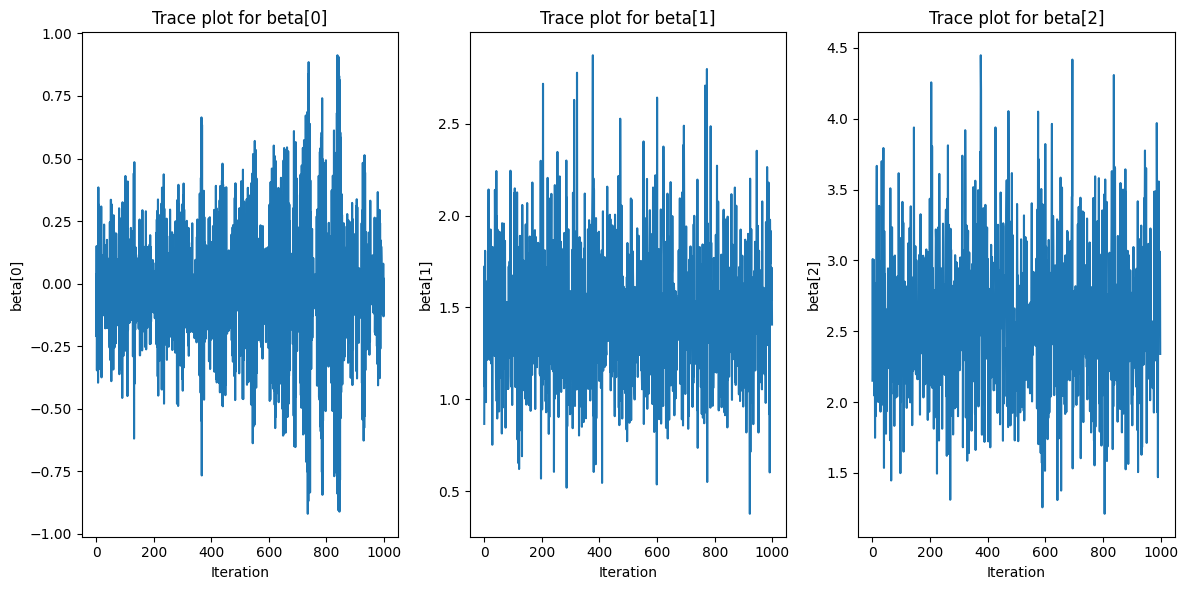

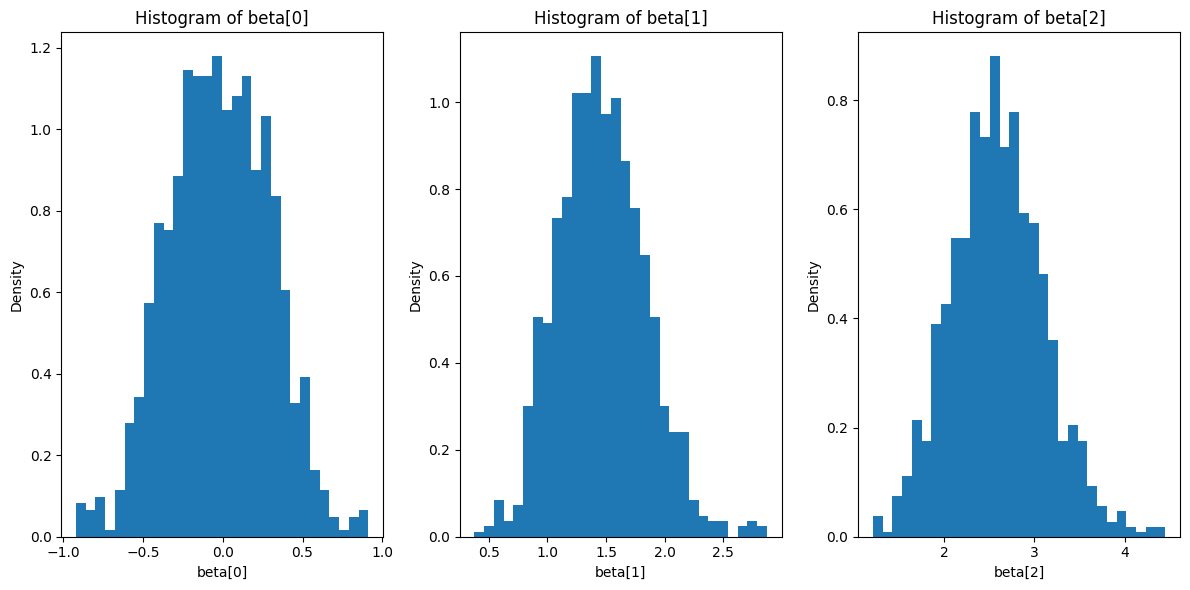

In [28]:
import matplotlib.pyplot as plt

samples = np.stack(samples)
# Plot the samples
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(samples[:, 0])
plt.xlabel('Iteration')
plt.ylabel('beta[0]')
plt.title('Trace plot for beta[0]')

plt.subplot(1, 3, 2)
plt.plot(samples[:, 1])
plt.xlabel('Iteration')
plt.ylabel('beta[1]')
plt.title('Trace plot for beta[1]')

plt.subplot(1, 3, 3)
plt.plot(samples[:, 2])
plt.xlabel('Iteration')
plt.ylabel('beta[2]')
plt.title('Trace plot for beta[2]')


plt.tight_layout()
plt.show()

# Plot the histogram of the samples
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(samples[:, 0], bins=30, density=True)
plt.xlabel('beta[0]')
plt.ylabel('Density')
plt.title('Histogram of beta[0]')

plt.subplot(1, 3, 2)
plt.hist(samples[:, 1], bins=30, density=True)
plt.xlabel('beta[1]')
plt.ylabel('Density')
plt.title('Histogram of beta[1]')

plt.subplot(1, 3, 3)
plt.hist(samples[:, 2], bins=30, density=True)
plt.xlabel('beta[2]')
plt.ylabel('Density')
plt.title('Histogram of beta[2]')

plt.tight_layout()
plt.show()